In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp

In [2]:
plt.style.use('fivethirtyeight')

# Data

In [3]:
HA_273 = -20000    # Standard enthalpy for A, cal/mol
HB_273 = -15000    # Standard enthalpy for B, cal/mol
HC_273 = -41000    # Standard enthalpy for C, cal/mol

To = 300.15        # Feed temperature, K
vo = 2             # inlet volumetruc flow rate, dm3/s
Cao = 0.1          # Initial concetration for A, mol/dm3

CpA = 15           # heat capacity for A, cal/mol/K
CpB = 15           # heat capacity for B, cal/mol/K
CpC = 30           # heat capacity for C, cal/mol/K

k_300 = 0.01       # kinetic constant at 300 K, dm3/mol/s
Ea = 10000         # Activation energy, cal/mol

Rgas = 1.987       # Universal gas constant, cal/mol/K

Xamax = 0.85

In [4]:
Fao = Cao * vo

In [5]:
Dh = HC_273 - HB_273 - HA_273

print('The reaction heat at 300K is {:.2f} cal/mol'.format(Dh))

The reaction heat at 300K is -6000.00 cal/mol


# PFR
# Part (a)

We need to solve the mole balance and energy balance, simultaneously

The mole balance:

\begin{align}
&\frac{dx}{dV} = -\frac{r_A}{F_{Ao}} \\
&r_A = - k(T) \, C_{Ao}^2 \, \left(1-x\right)^2\\
&k(T) = k(300) \exp\left(\frac{-Ea}{R}\left( \frac{1}{T}-\frac{1}{300}\right)\right)
\end{align}

The energy balance

\begin{equation} 
T = To - \frac{\Delta H\, x}{\sum{\theta_i \, Cp_i} + \Delta Cp \, x}
\end{equation}

In [6]:
def system(x, v):
    t = To - (Dh * x) / (CpA + CpB)
    k = k_300 * np.exp(-Ea/Rgas * (1/t - 1/To))
    
    ra = -k * Cao**2 * (1-x)**2
    
    dv_dx = -Fao / ra
    return dv_dx
    

In [7]:
# initial condition
ICs = [0]            # the initial volume of the reactor is 0

xspan = [0, Xamax]  #  independent variable range

solODE = solve_ivp(system, xspan, ICs, t_eval=np.linspace(0, Xamax))

In [8]:
print('The reactor volume is {:.2f} dm^3'.format(solODE.y[0][-1]))

The reactor volume is 305.10 dm^3


The temperature profile is calculated from the energy balance based on the conversion profile

In [9]:
Temp = To - (Dh * solODE.t) / (CpA + CpB)

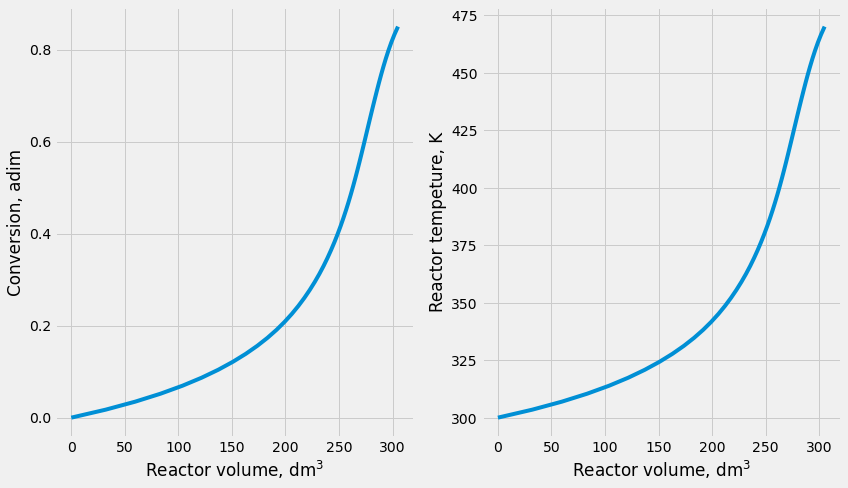

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

ax1.plot(solODE.y[0], solODE.t)
ax1.set_xlabel(r'Reactor volume, dm$^3$')
ax1.set_ylabel('Conversion, adim')

ax2.plot(solODE.y[0], Temp)
ax2.set_xlabel(r'Reactor volume, dm$^3$')
ax2.set_ylabel('Reactor tempeture, K')

plt.tight_layout()
plt.show()

## Part (b)

This part is direct because can be calculated from the energy balance

\begin{equation}
Tf = To - \frac{\Delta H_r \, X}{CpA + CpB}
\end{equation}

Therefore


\begin{equation}
To = Tf + \frac{\Delta H_r \, X}{CpA + CpB}
\end{equation}

In [11]:
Tf_max = 550
To_max = Tf_max + Dh * Xamax / (CpA + CpB)

print('The maximum inlet temperature is {:.2f} K'.format(To_max))

The maximum inlet temperature is 380.00 K


## Part (c)

The heat that should be removed is the heat of reaction times fractional conversion


In [12]:
heat_to_be_removed = -Dh * solODE.t

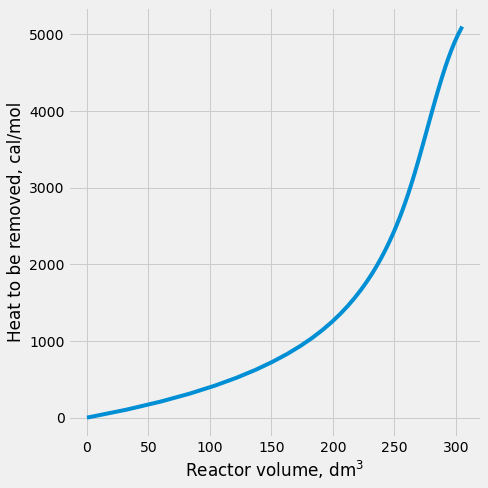

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(solODE.y[0], heat_to_be_removed)
ax.set_xlabel(r'Reactor volume, dm$^3$')
ax.set_ylabel('Heat to be removed, cal/mol')


plt.tight_layout()
plt.show()

## Part (d)

This part requires to change the kinetic law and include the equilibrium constant into the system

The mole balance:

\begin{align}
&\frac{dx}{dV} = -\frac{r_A}{F_{Ao}} \\
&r_A = - k(T) \left(C_A \,C_B - \frac{C_C}{K_c(T)} \right) \\
&k(T) = k(300) \exp\left(\frac{-Ea}{R}\left( \frac{1}{T}-\frac{1}{300}\right)\right)\\
&Kc(T) = k(450) \exp\left(\frac{-\Delta H}{R}\left( \frac{1}{T}-\frac{1}{450}\right)\right)
\end{align}

with
\begin{align}
&C_A = C_{Ao} \, (1 - x) \\
&C_B = C_{Bo} - C_{Ao} \, x \\
&C_C = C_{Ao} \, x
\end{align}

In [14]:
Vreactor = 10
Kc_450 = 10

In [23]:
def system2(v, x):
    t = To - (Dh * x) / (CpA + CpB)
    k = k_300 * np.exp(-Ea/Rgas * (1/t - 1/To))
    Kc = Kc_450 * np.exp(-Dh/Rgas * (1/t - 1/To))
    
    Ca = Cao * (1-x)
    Cb = Ca
    Cc = Cao * x
    
    ra = -k * (Ca * Cb - Cc/ Kc)
    
    dx_dv = -ra / Fao
    return dx_dv
    

In [24]:
vspan = [0, Vreactor]  #  independent variable range

solODE2 = solve_ivp(system2, vspan, ICs, t_eval=np.linspace(0, Vreactor))

Temp2 = To - (Dh * solODE2.y[0]) / (CpA + CpB)

Let plot both results for the same reactor size (10 dm^3)

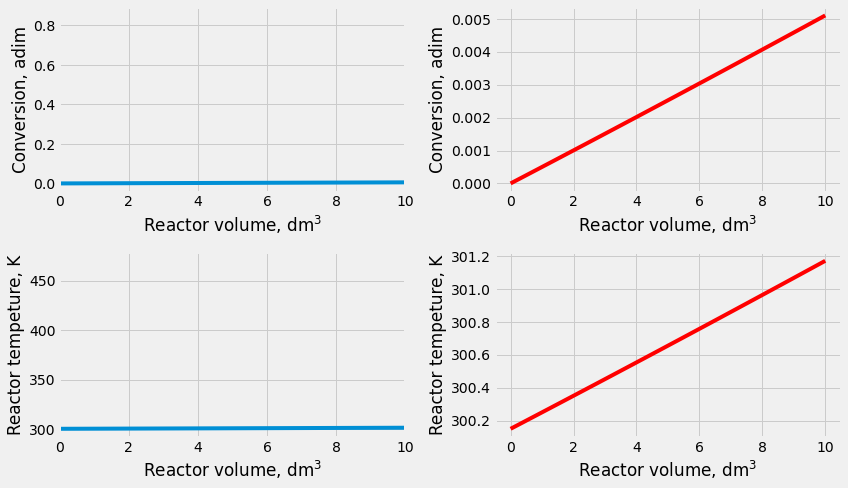

In [29]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 7))

ax1.plot(solODE.y[0], solODE.t)
ax1.set_xlabel(r'Reactor volume, dm$^3$')
ax1.set_ylabel('Conversion, adim')
ax1.set_xlim([0,10])

ax2.plot(solODE2.t, solODE2.y[0], color='red')
ax2.set_xlabel(r'Reactor volume, dm$^3$')
ax2.set_ylabel('Conversion, adim')

ax3.plot(solODE.y[0], Temp)
ax3.set_xlabel(r'Reactor volume, dm$^3$')
ax3.set_ylabel('Reactor tempeture, K')
ax3.set_xlim([0,10])

ax4.plot(solODE2.t, Temp2, color='red')
ax4.set_xlabel(r'Reactor volume, dm$^3$')
ax4.set_ylabel('Reactor tempeture, K')

plt.tight_layout()
plt.show()

In [30]:
print('The final conversion for the reversible scenario is {:.3f}'.format(solODE2.y[0][-1]))

The final conversion for the reversible scenario is 0.005


In [32]:
print('The final temperature for the reversible scenario is {:.2f} K'.format(Temp2[-1]))

The final temperature for the reversible scenario is 301.17 K


At the equilibrium

\begin{equation}
k(T)\,C_A\,C_B = \frac{k(T)\,C_C}{K_C(T)}
\end{equation}